### RNN, LSTM 돌려보기 3: 열 4개 데이터로, chatGPT 사용
이번에는 열을 'Open', 'High', 'Low', 'Close' 4개 사용해 돌려봄   
열을 여러 개 사용할 때(다변량 입력)는 두 가지 출력이 나올 수 있음:
1. 단일 출력
2. 다변량 출력(열 전부를 각각 예측)

chatGPT의 의견: 일반적으로는 다변량 입력 -> 단일 출력이 더 실용적!   
그러니 이번에는 다변량 입력 -> 단일 출력을 해볼 것

In [37]:
# 라이브러리

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense

#### 데이터 다루기

In [38]:
# 1. 데이터 불러오기
df = pd.read_csv('../AAME.csv')

# 2. OHLC 열만 사용
ohlc = df[['Open', 'High', 'Low', 'Close']].values

In [39]:
# 3. 데이터 정규화 (0~1 스케일로)
scaler = MinMaxScaler()
scaled_ohlc = scaler.fit_transform(ohlc)

In [40]:
# 4. 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])         # (seq_length, 4)
        y.append(data[i+seq_length][0])        # 다음날 Open만
    return np.array(X), np.array(y)

# 5. 시퀀스 생성
sequence_length = 30
X, y = create_sequences(scaled_ohlc, sequence_length)

In [41]:
# 6. 훈련/검증 데이터 분할
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

#### RNN

In [42]:
# 7-1. RNN 모델 정의
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, input_shape=(sequence_length, 4)))
model.add(SimpleRNN(32))
model.add(Dense(1))  # Open만 예측

model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'mae'])

model.summary()

c:\Users\jt341\anaconda3\envs\2025AI\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 30, 64)         │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,553 (29.50 KB)

 Trainable params: 7,553 (29.50 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# 8. 모델 학습
history = model.fit(X_train, y_train, epochs=5, batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0098 - mae: 0.0519 - mse: 0.0098 - val_loss: 0.0041 - val_mae: 0.0629 - val_mse: 0.0041
Epoch 2/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035 - mae: 0.0285 - mse: 0.0035 - val_loss: 0.0013 - val_mae: 0.0351 - val_mse: 0.0013
Epoch 3/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0033 - mae: 0.0263 - mse: 0.0033 - val_loss: 1.1925e-04 - val_mae: 0.0083 - val_mse: 1.1925e-04
Epoch 4/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0033 - mae: 0.0251 - mse: 0.0033 - val_loss: 1.3656e-04 - val_mae: 0.0093 - val_mse: 1.3656e-04
Epoch 5/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026 - mae: 0.0227 - mse: 0.0026 - val_loss: 5.2047e-04 - val_mae: 0.0214 - val_mse: 5.2047e-04


#### LSTM

In [44]:
# 7. LSTM 모델 정의 (2층 LSTM)
model2 = Sequential()
model2.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, 4)))
model2.add(LSTM(32))
model2.add(Dense(1))  # Open만 예측하므로 1

model2.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'mae'])

model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,113 (117.63 KB)

 Trainable params: 30,113 (117.63 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# 8. 모델 학습
history2 = model2.fit(X_train, y_train, epochs=5, batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0061 - mae: 0.0388 - mse: 0.0061 - val_loss: 1.0361e-04 - val_mae: 0.0072 - val_mse: 1.0361e-04
Epoch 2/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0033 - mae: 0.0236 - mse: 0.0033 - val_loss: 3.4274e-04 - val_mae: 0.0164 - val_mse: 3.4274e-04
Epoch 3/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0034 - mae: 0.0205 - mse: 0.0034 - val_loss: 3.3562e-04 - val_mae: 0.0163 - val_mse: 3.3562e-04
Epoch 4/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0031 - mae: 0.0203 - mse: 0.0031 - val_loss: 3.6048e-04 - val_mae: 0.0171 - val_mse: 3.6048e-04
Epoch 5/5
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0040 - mae: 0.0235 - mse: 0.0040 - val_loss: 8.6946e-05 - val_mae: 0.0068 - val_mse: 8.6946e-05


#### 모델 평가

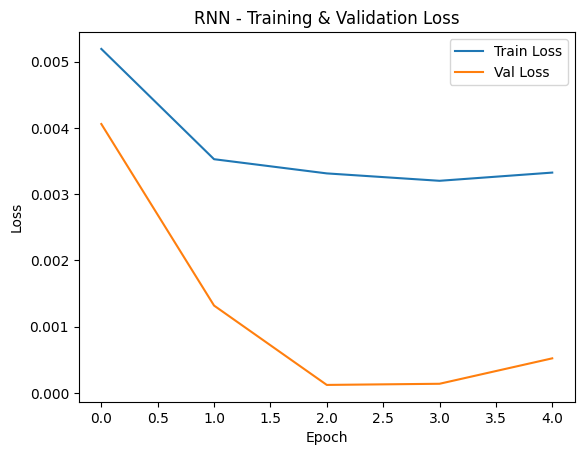

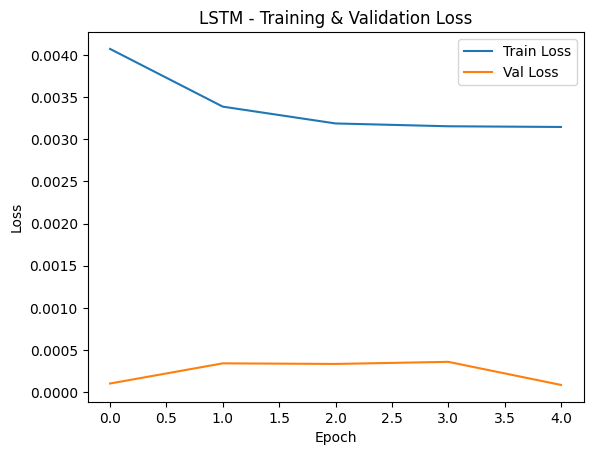

In [46]:
# 9. 학습 곡선 시각화
# RNN
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('RNN - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# LSTM
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('LSTM - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# 10. 예측 및 역정규화
# RNN
predicted = model.predict(X_test)

# 예측 결과 역정규화: y값(Open)만 따로 복원
# 방법: 예측값 → 4열 dummy와 결합 → scaler.inverse_transform → 첫 열만 추출
def invert_scaling(y_scaled):
    dummy = np.zeros((len(y_scaled), 4))
    dummy[:, 0] = y_scaled.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

predicted_open = invert_scaling(predicted)
actual_open = invert_scaling(y_test.reshape(-1, 1))

# LSTM
predicted2 = model2.predict(X_test)

# 예측 결과 역정규화: y값(Open)만 따로 복원
# 방법: 예측값 → 4열 dummy와 결합 → scaler.inverse_transform → 첫 열만 추출
def invert_scaling(y_scaled):
    dummy = np.zeros((len(y_scaled), 4))
    dummy[:, 0] = y_scaled.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

predicted_open2 = invert_scaling(predicted2)
actual_open2 = invert_scaling(y_test.reshape(-1, 1))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


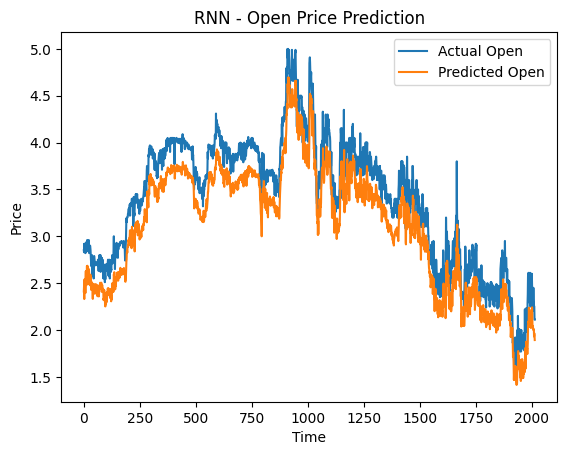

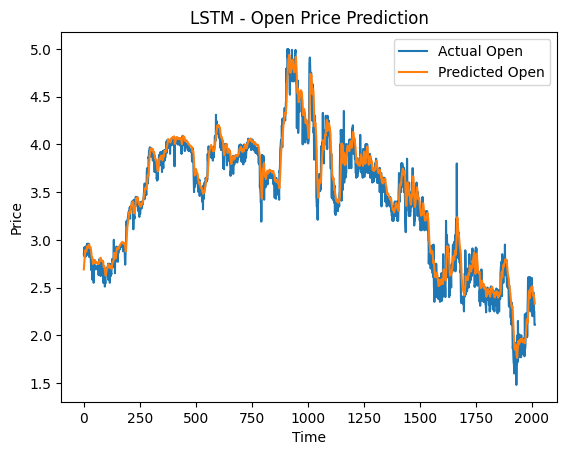

In [ ]:
# 11. 예측 결과 시각화
# RNN
plt.plot(actual_open, label='Actual Open')
plt.plot(predicted_open, label='Predicted Open')
plt.title('RNN - Open Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# LSTM
plt.plot(actual_open2, label='Actual Open')
plt.plot(predicted_open2, label='Predicted Open')
plt.title('LSTM - Open Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

#### 간단 평가
이번에는 RNN, LSTM 모두 단층이 아닌 2층 모델을 사용했는데, LSTM이 RNN에 비해 loss가 평균적으로 더 적고 예측 정확도가 높았다.   
LSTM이 가중치 손실을 더 적게 일으키기 때문에 층이 쌓여도 정확도를 유지할 수 있는 게 아닐까 싶다.